# Keras: Tabular Regression

*Using Kepler Satellite Sensor Data to Predict Exoplanet Surface Temperature.*

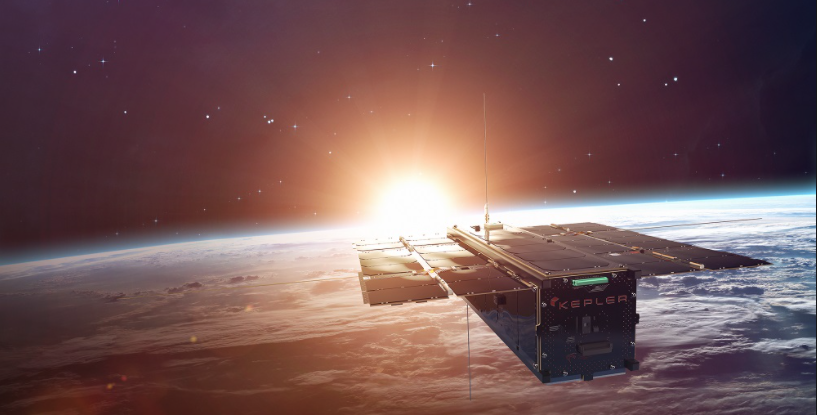

Reference this great blog for machine learning cookbooks: [MachineLearningMastery.com "Regression"](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/).

In [2]:
import keras
from keras import metrics
from keras.models import Sequential
from keras.callbacks import Callback, History
from keras.layers import Input, Dense, BatchNormalization, Activation, Dropout

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

import aiqc
from aiqc import datum

---

## Example Data

Reference [Example Datasets](example_datasets.ipynb) for more information.

In [3]:
df = datum.to_pandas('exoplanets.parquet')

In [4]:
df.head()

,TypeFlag,PlanetaryMassJpt,PeriodDays,SurfaceTempK,DistFromSunParsec,HostStarMassSlrMass,HostStarRadiusSlrRad,HostStarMetallicity,HostStarTempK
5,0,0.2500,19.224180,707.2,650.00,1.070,1.0200,0.12,5777.0
6,0,0.1700,39.031060,557.9,650.00,1.070,1.0200,0.12,5777.0
7,0,0.0220,1.592851,1601.5,650.00,1.070,1.0200,0.12,5777.0
15,0,1.2400,2.705782,2190.0,200.00,1.630,2.1800,0.12,6490.0
16,0,0.0195,1.580404,604.0,14.55,0.176,0.2213,0.10,3250.0


In [5]:
df.dtypes

TypeFlag                  int64
PlanetaryMassJpt        float64
PeriodDays              float64
SurfaceTempK            float64
DistFromSunParsec       float64
HostStarMassSlrMass     float64
HostStarRadiusSlrRad    float64
HostStarMetallicity     float64
HostStarTempK           float64
dtype: object

---

## a) High-Level API

Reference [High-Level API Docs](api_high_level.ipynb) for more information including how to work with non-tabular data.

### Preprocess Data

In [6]:
splitset = aiqc.Pipeline.Tabular.make(
    df_or_path = df
    , dtype = None

    , feature_cols_excluded = 'SurfaceTempK'
    , feature_interpolaters = None
    , feature_window = None
    , feature_encoders = [
        {"dtypes": ['float64'], "sklearn_preprocess": RobustScaler(copy=False)},
        {"dtypes": ['int64'], "sklearn_preprocess": OneHotEncoder(sparse=False)}
    ]
    , feature_reshape_indices = None

    , label_column = 'SurfaceTempK'
    , label_interpolater = None
    , label_encoder = dict(sklearn_preprocess = StandardScaler(copy=False))

    , size_test = 0.12
    , size_validation = 0.22
    , fold_count = None
    , bin_count = 4
)


___/ featurecoder_index: 0 \_________

=> The column(s) below matched your filter(s) featurecoder filters.

['PlanetaryMassJpt', 'PeriodDays', 'DistFromSunParsec', 'HostStarMassSlrMass', 'HostStarRadiusSlrRad', 'HostStarMetallicity', 'HostStarTempK']

=> The remaining column(s) and dtype(s) are available for downstream featurecoder(s):
{'TypeFlag': 'int64'}


___/ featurecoder_index: 1 \_________

=> The column(s) below matched your filter(s) featurecoder filters.

['TypeFlag']

=> Done. All feature column(s) have featurecoder(s) associated with them.
No more Featurecoders can be added to this Encoderset.



### Build Model

In [7]:
def fn_build(features_shape, label_shape, **hp):
    
    model = Sequential()
    
    model.add(Input(shape=features_shape))

    # Example of using hyperparameters to tweak topology.
    # with 'block' for each layer.
    for b in range(hp['blocks']):
        # Example of using hyperparameters to tweak topology.
        model.add(Dense(hp['neuron_count']))
        
        # Example of using hyperparameters to tweak topology. 
        # BatchNorm, Activation, Dropout (B.A.D.)
        if (hp['batch_norm'] == True):
            model.add(BatchNormalization())
      
        model.add(Activation('relu'))
        model.add(Dropout(0.2))
    
                  
    model.add(Dense(label_shape[0]))
    
    return model

In [8]:
def fn_train(model, loser, optimizer, samples_train, samples_evaluate, **hp):
    
    model.compile(
        loss = loser
        , optimizer = optimizer
        , metrics = ['mean_squared_error']
    )
    
    metrics_cuttoffs = [
        {"metric":"val_loss", "cutoff":0.025, "above_or_below":"below"},
        {"metric":"loss", "cutoff":0.025, "above_or_below":"below"}
    ]
    cutoffs = aiqc.TrainingCallback.Keras.MetricCutoff(metrics_cuttoffs)
    
    model.fit(
        samples_train["features"]
        , samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = hp['batch_size']
        , callbacks=[History(), cutoffs]
        , epochs = hp['epoch_count']
    )
    return model

### Stage Experiment

In [9]:
hyperparameters = {
    "batch_size": [3]
    , "blocks": [2]
    , "batch_norm": [True, False]
    , "epoch_count": [75]
    , "neuron_count": [24, 36]
    , "learning_rate": [0.01]
}

In [10]:
queue = aiqc.Experiment.make(
    
    library = "keras"
    , analysis_type = "regression"
    
    
    , fn_build = fn_build
    , fn_train = fn_train
    , fn_predict = None
    , fn_lose = None  #optional, boilerplate regression.
    , fn_optimize = None
    
    
    , splitset_id = splitset.id
    , foldset_id = None

    
    , repeat_count = 1
    , hide_test = False
    , hyperparameters = hyperparameters
)

In [11]:
queue.run_jobs()

🔮 Training Models 🔮:   0%|                                                  | 0/4 [00:00<?, ?it/s]

🔮 Training Models 🔮:  25%|██████████▌                               | 1/4 [00:26<01:19, 26.64s/it]

🔮 Training Models 🔮:  50%|█████████████████████                     | 2/4 [00:38<00:35, 17.76s/it]

🔮 Training Models 🔮:  75%|███████████████████████████████▌          | 3/4 [00:46<00:13, 13.60s/it]

🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 4/4 [00:55<00:00, 13.88s/it]


For more information on visualization of performance metrics, reference the [Visualization & Metrics](visualization.html) documentation.

---

## b) Low-Level API

Reference [Low-Level API Docs](api_low_level.ipynb) for more information including how to work with non-tabular data, and defining an optimizer.

### Preprocess Data

In [12]:
dataset = aiqc.Dataset.Tabular.from_pandas(df)

In [13]:
label_column = 'SurfaceTempK'

In [14]:
label = dataset.make_label(columns=[label_column])

In [15]:
labelcoder = label.make_labelcoder(
    sklearn_preprocess = StandardScaler(copy=False)
)

In [16]:
feature = dataset.make_feature(exclude_columns=[label_column])

In [17]:
encoderset = feature.make_encoderset()

In [18]:
featurecoder_0 = encoderset.make_featurecoder(
    sklearn_preprocess = RobustScaler(copy=False)
    , dtypes = ['float64']
)


___/ featurecoder_index: 0 \_________

=> The column(s) below matched your filter(s) featurecoder filters.

['PlanetaryMassJpt', 'PeriodDays', 'DistFromSunParsec', 'HostStarMassSlrMass', 'HostStarRadiusSlrRad', 'HostStarMetallicity', 'HostStarTempK']

=> The remaining column(s) and dtype(s) are available for downstream featurecoder(s):
{'TypeFlag': 'int64'}



In [19]:
featurecoder_1 = encoderset.make_featurecoder(
    sklearn_preprocess = OneHotEncoder(sparse=False)
    , dtypes = ['int64']
)


___/ featurecoder_index: 1 \_________

=> The column(s) below matched your filter(s) featurecoder filters.

['TypeFlag']

=> Done. All feature column(s) have featurecoder(s) associated with them.
No more Featurecoders can be added to this Encoderset.



In [20]:
splitset = aiqc.Splitset.make(
    feature_ids = [feature.id]
    , label_id = label.id
    , size_test = 0.22
    , size_validation = 0.12
)

### Build Model

In [21]:
def fn_build(features_shape, label_shape, **hp):
    
    model = Sequential()
    
    model.add(Input(shape=features_shape))

    # Example of using hyperparameters to tweak topology.
    # with 'block' for each layer.
    for b in range(hp['blocks']):
        # Example of using hyperparameters to tweak topology.
        model.add(Dense(hp['neuron_count']))
        
        # Example of using hyperparameters to tweak topology. 
        # BatchNorm, Activation, Dropout (B.A.D.)
        if (hp['batch_norm'] == True):
            model.add(BatchNormalization())
      
        model.add(Activation('relu'))
        model.add(Dropout(0.2))
    
                  
    model.add(Dense(label_shape[0]))
    
    return model

In [22]:
def fn_train(model, loser, optimizer, samples_train, samples_evaluate, **hp):
    
    model.compile(
        loss = loser
        , optimizer = optimizer
        , metrics = ['mean_squared_error']
    )
    
    metrics_cuttoffs = [
        {"metric":"val_loss", "cutoff":0.025, "above_or_below":"below"},
        {"metric":"loss", "cutoff":0.025, "above_or_below":"below"}
    ]
    cutoffs = aiqc.TrainingCallback.Keras.MetricCutoff(metrics_cuttoffs)
    
    model.fit(
        samples_train["features"]
        , samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = hp['batch_size']
        , callbacks=[History(), cutoffs]
        , epochs = hp['epoch_count']
    )
    return model

In [23]:
algorithm = aiqc.Algorithm.make(
    library = "keras"
    , analysis_type = "regression"
    , fn_build = fn_build
    , fn_train = fn_train
)

### Stage Experiment

In [24]:
hyperparameters = {
    "batch_size": [3]
    , "blocks": [2]
    , "batch_norm": [True, False]
    , "epoch_count": [75]
    , "neuron_count": [24, 36]
    , "learning_rate": [0.01]
}

In [25]:
hyperparamset = algorithm.make_hyperparamset(
    hyperparameters = hyperparameters
)

In [26]:
queue = algorithm.make_queue(
    splitset_id = splitset.id
    , hyperparamset_id = hyperparamset.id
    , repeat_count = 1
)

In [27]:
queue.run_jobs()

🔮 Training Models 🔮:   0%|                                                  | 0/4 [00:00<?, ?it/s]

🔮 Training Models 🔮:  25%|██████████▌                               | 1/4 [00:10<00:32, 10.72s/it]

🔮 Training Models 🔮:  50%|█████████████████████                     | 2/4 [00:21<00:21, 10.60s/it]

🔮 Training Models 🔮:  75%|███████████████████████████████▌          | 3/4 [00:29<00:09,  9.50s/it]

🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 4/4 [00:37<00:00,  9.41s/it]


For more information on visualization of performance metrics, reference the [Visualization & Metrics](visualization.html) documentation.